<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/portfolio/momentum_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install riskfolio-lib --q

In [46]:
import riskfolio as rp
import warnings

warnings.filterwarnings("ignore")

In [47]:
import pandas as pd
import yfinance as yf

def get_nifty50_tickers():
    data = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/STOCKS100.txt', sep='\t')
    nifty100 = data['yahoo finance ticker'].tolist()
    return nifty100


def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

In [48]:
nifty50_tickers = get_nifty50_tickers()

start_date = '2022-01-01'
end_date = '2024-01-28'

In [ ]:
# Define the rolling windows for different time periods
rolling_periods = [21, 63, 126, 262]
top_decile_stocks = []
# Calculate rolling returns for each time period
for symbol in nifty50_tickers:
    stock_data = fetch_stock_data(symbol, start_date, end_date)

    if len(stock_data) > 262:
        returns_21 = stock_data['Close'].pct_change(21)
        returns_63 = stock_data['Close'].pct_change(63)
        returns_126= stock_data['Close'].pct_change(126)
        returns_252= stock_data['Close'].pct_change(252)


        # Append relevant information to the list
        top_decile_stocks.append({
            'Symbol': symbol,
            'Close': stock_data['Close'].iloc[-1],
            'returns_21': returns_21.iloc[-1],
            'returns_63': returns_63.iloc[-1],
            'returns_126':returns_126.iloc[-1],
            'returns_252':returns_252.iloc[-1],
        })

In [50]:
top_decile_stocks[0:10]

[{'Symbol': 'ongc.ns',
  'Close': 234.0500030517578,
  'returns_21': 0.12876776543190793,
  'returns_63': 0.2661617274748169,
  'returns_126': 0.3723248247654929,
  'returns_252': 0.5857045621503065},
 {'Symbol': 'indigo.ns',
  'Close': 2863.050048828125,
  'returns_21': -0.01987266676506616,
  'returns_63': 0.19745294016918247,
  'returns_126': 0.06884070453665103,
  'returns_252': 0.3632598538004286},
 {'Symbol': 'tcs.ns',
  'Close': 3810.300048828125,
  'returns_21': 0.0038861297599155353,
  'returns_63': 0.11734092574914579,
  'returns_126': 0.13122346394103968,
  'returns_252': 0.14284428638598134},
 {'Symbol': 'tatamotors.ns',
  'Close': 811.8499755859375,
  'returns_21': 0.1282746012908358,
  'returns_63': 0.2541129314959898,
  'returns_126': 0.2974030772448062,
  'returns_252': 0.9657384396753934},
 {'Symbol': 'hdfcbank.ns',
  'Close': 1434.9000244140625,
  'returns_21': -0.14713657698131632,
  'returns_63': -0.047242802103041104,
  'returns_126': -0.14372667497295988,
  'retur

In [51]:

# Create the DataFrame
df = pd.DataFrame(top_decile_stocks)

# Calculate composite scores
df['Composite Score'] = df[['returns_21', 'returns_63', 'returns_126', 'returns_252']].mean(axis=1)

# Sort by composite score (descending) and assign ranks
df['Rank'] = df['Composite Score'].rank(ascending=False,method='dense')

# Display the results
df[['Symbol', 'Composite Score', 'Rank']].head(10)

,Symbol,Composite Score,Rank
0,ongc.ns,0.338240,19.0
1,indigo.ns,0.152420,40.0
2,tcs.ns,0.098824,55.0
3,tatamotors.ns,0.411382,15.0
4,hdfcbank.ns,-0.108244,92.0
5,ofss.ns,0.806166,2.0
6,wipro.ns,0.141735,43.0
7,infy.ns,0.153385,39.0
8,hindzinc.ns,-0.017302,80.0
9,nestleind.ns,0.083631,60.0


In [52]:
# Sort by Composite Score in descending order
df = df.sort_values(by=['Composite Score'], ascending=False)

# Assign ranks based on sorted order
#df['Rank'] = np.arange(len(df)) + 1

# Display the results (top 10 only)
print(df[['Symbol', 'Composite Score', 'Rank']].head(10))

           Symbol  Composite Score  Rank
61         PFC.NS         1.142922   1.0
5         ofss.ns         0.806166   2.0
65        NHPC.NS         0.707728   3.0
76       GICRE.NS         0.629392   4.0
89  AUROPHARMA.NS         0.612833   5.0
14  BAJAJ-AUTO.NS         0.565885   6.0
93        NMDC.NS         0.542807   7.0
82         PNB.NS         0.531168   8.0
91         DLF.NS         0.507519   9.0
52   HINDPETRO.NS         0.504326  10.0


In [53]:
assets=df['Symbol'].head(10).tolist()
Uc_assets = [x.upper() for x in assets]


In [54]:
assets_dataframe=yf.download(assets,start=start_date,end=end_date)['Close']
Y= assets_dataframe[Uc_assets].pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [55]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'UCI' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 9.0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)



In [56]:
display(w.T*100)

,PFC.NS,OFSS.NS,NHPC.NS,GICRE.NS,AUROPHARMA.NS,BAJAJ-AUTO.NS,NMDC.NS,PNB.NS,DLF.NS,HINDPETRO.NS
weights,19.935952,11.644345,8.119085,12.48207,7.860525,2.992423,9.734023,12.33284,1.374861,13.523877


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [57]:
display(w.T*100)

,PFC.NS,OFSS.NS,NHPC.NS,GICRE.NS,AUROPHARMA.NS,BAJAJ-AUTO.NS,NMDC.NS,PNB.NS,DLF.NS,HINDPETRO.NS
weights,19.935952,11.644345,8.119085,12.48207,7.860525,2.992423,9.734023,12.33284,1.374861,13.523877


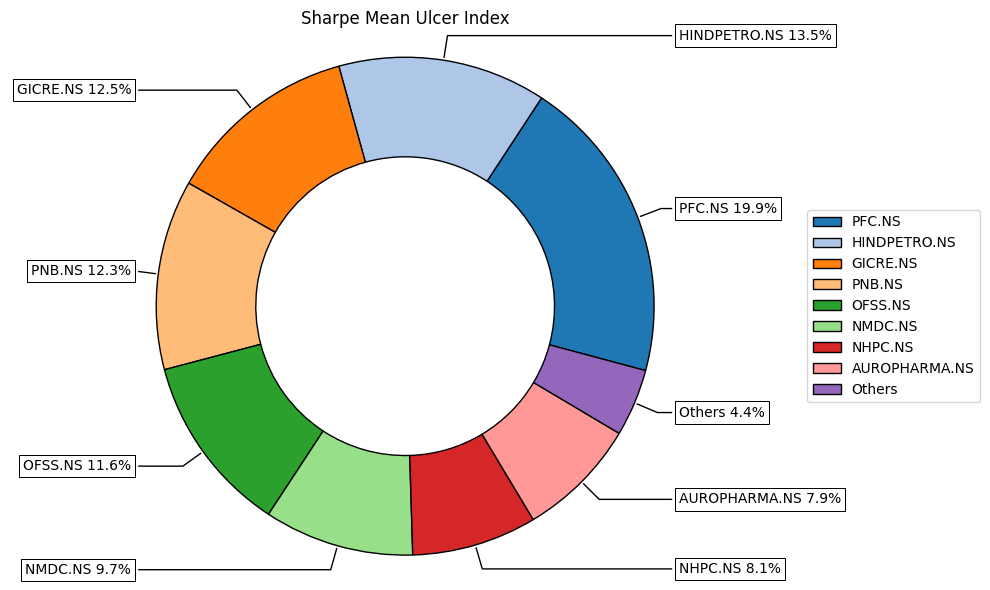

In [58]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Ulcer Index', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

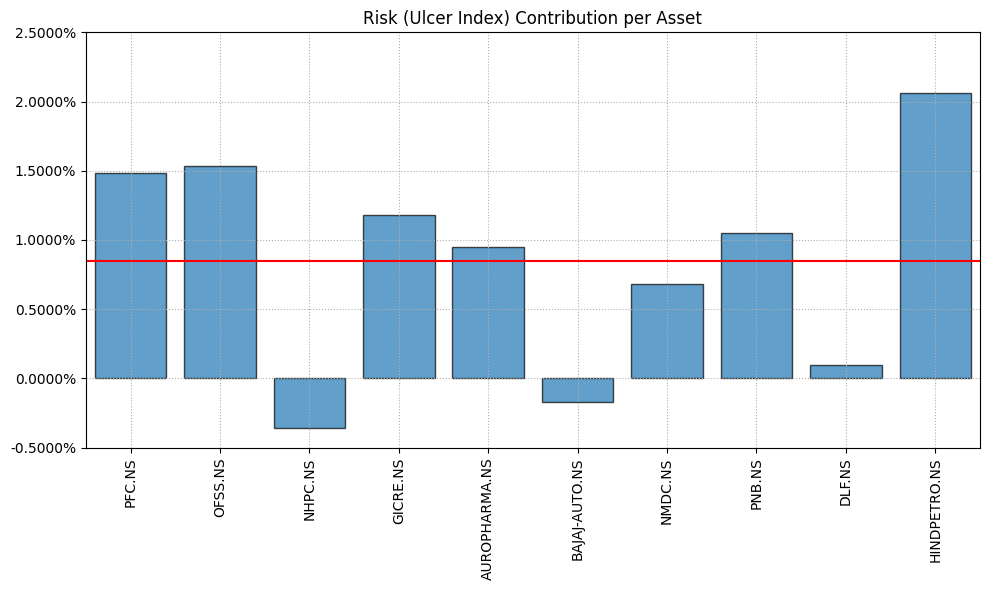

In [59]:
ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

February 2024

|index|OFSS\.NS|PFC\.NS|HINDPETRO\.NS|PNB\.NS|DLF\.NS|GICRE\.NS|IOC\.NS|ADANIPORTS\.NS|NHPC\.NS|BAJAJ-AUTO\.NS|
|---|---|---|---|---|---|---|---|---|---|---|
|weights|11\.369589812358923|20\.052978999269733|13\.140136075115278|11\.754298083341052|0\.0004881335353018651|13\.209756686041954|8\.634034436208067|9\.234507501854768|8\.991530442658123|3\.6126798296168015|


January 2024

|index|PFC\.NS|OFSS\.NS|NHPC\.NS|GICRE\.NS|AUROPHARMA\.NS|BAJAJ-AUTO\.NS|NMDC\.NS|PNB\.NS|DLF\.NS|HINDPETRO\.NS|
|---|---|---|---|---|---|---|---|---|---|---|
|weights|19\.9359517241607|11\.644344545584069|8\.119085100588297|12\.482069877947783|7\.860525413315095|2\.992422884219905|9\.734022841420229|12\.332839597407245|1\.374861273536692|13\.523876741819981|
